<a href="https://colab.research.google.com/github/zahraDehghanian97/Brain_cancer_classification/blob/master/Brain_Tumor_MRI_Image_Classification_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Cancer MRI Images Classification

Cancer is the second leading cause of death after cardiovascular diseases. Out of all types of cancer, brain cancer has the lowest survival rate. Brain tumors can have different types depending on several factors such as the shape, texture, and location of the tumor (e.g., Acoustic Neuroma, Meningioma, Pituitary, Glioma, CNS Lymphoma . . . etc). In clinical practice, the incident rates of Glioma, Meningioma, and Pituitary tumors are approximately 45%, 15%, and 15%, respectively, among all brain tumors. Proper diagnosis of the tumor type enables the doctor to make the correct treatment choice and help save the patient’s life.


Currently, anomaly detection through MRI is manual mostly and clinicians have to spend a lot of time to detect and segment the tumor for treatment and surgical purpose. This manual technique is also prone to errors and can compromise life. Also, diversity of Tumor types, makes the detection more difficult due to the complex structure of the brain. In order to resolve these issues, studies have started to focus on various machine learning and Deep Learning techniques for computer-based tumor detection and segmentation.


 [This paper](https://www.sciencedirect.com/science/article/abs/pii/S0895611121000896?via%3Dihub) reviews different papers that tried to do the task of brain cancer MRI image classification. In this project, we will implement and compare some of these methods.

## **2. Setting Up Local Storage for Dataset**

### **2.1 Giving Access To Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


## **3. Importing Required Libraries**

In [3]:
import sys
import os
import math
import h5py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import keras
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras import backend as backend
from tensorflow.keras.callbacks import EarlyStopping
import cv2
 
print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.9.2.


### **4.3 Setting Up Paths to Root and Data Directories**

In [4]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer')
!ls     

#Create a directory named dataset
!mkdir dataset
!ls -a

dataset


In [5]:
#Download Files
from google.colab import files
import requests 
file_url = "https://ndownloader.figshare.com/articles/1512427/versions/5"
	
r = requests.get(file_url, stream = True) 

with open("/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/data.zip", "wb") as file: 
	for block in r.iter_content(chunk_size = 1024): 
		if block: 
			file.write(block) 


In [6]:
#Unzip data
!unzip -q data.zip -d dataset/


In [7]:
import zipfile
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/dataset/brainTumorDataPublic_1-766.zip', 'r') as zip_ref:
   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/Training')
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/dataset/brainTumorDataPublic_767-1532.zip', 'r') as zip_ref:
   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/Training')
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/dataset/brainTumorDataPublic_1533-2298.zip', 'r') as zip_ref:
   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/Training')
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/dataset/brainTumorDataPublic_2299-3064.zip', 'r') as zip_ref:
   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/Training')


In [27]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer')
!mkdir CleanData
!ls
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/CleanData')
!mkdir meningioma
!mkdir glioma
!mkdir pituitary_tumor
!ls


CleanData  dataset  data.zip  Training
glioma	meningioma  pituitary_tumor


In [28]:
def mat_file_to_dict(filepath: str) -> dict:
    tumor_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary_tumor'}
    tumor_data_dict = {}
    with h5py.File(filepath, mode = 'r') as image_data:
        cjdata_struct = image_data['cjdata']
        id  = ""
        for i in range (len(cjdata_struct['PID'])):
          id = id+str(cjdata_struct['PID'][i][0])
        tumor_data_dict['PID'] = int(id)
        tumor_data_dict['class'] = tumor_class[int(cjdata_struct['label'][0, 0])]
        img1 = np.array(cjdata_struct['image'])
        tumor_data_dict['image'] =  cv2.merge((img1,img1,img1))//3
    return tumor_data_dict

In [29]:
rootpath_dataset = '/content/gdrive/My Drive/Colab Notebooks/Brain Cancer'
mat_dirname = os.path.join(rootpath_dataset,'Training')
training_dir = os.path.join(rootpath_dataset, 'CleanData')
m_path = os.path.join(training_dir, 'meningioma')
g_path = os.path.join(training_dir, 'glioma')
p_path = os.path.join(training_dir, 'pituitary_tumor')
data = []
labels = []
m_count, g_count, p_count = (0, 0, 0)
for root, dirpath, filenames in os.walk(mat_dirname):
    for curr_file in filenames :
        mri_img_data = mat_file_to_dict(os.path.join(root, curr_file))
        data.append(mri_img_data)
        tumor_class = mri_img_data['class']
        id = mri_img_data['PID']
        image=mri_img_data['image']
        if tumor_class == 'meningioma':
            m_count += 1
            cv2.imwrite( os.path.join(m_path, f'M{m_count}_{id}.jpg'),image)
        elif tumor_class == 'glioma':
            g_count += 1            
            cv2.imwrite( os.path.join(g_path, f'G{g_count}_{id}.jpg'),image)
        elif tumor_class == 'pituitary_tumor':
            p_count += 1
            cv2.imwrite( os.path.join(p_path, f'P{p_count}_{id}.jpg'),image)
        else:
            pass
df_images = pd.DataFrame(data)

## **5. Data Preprocessing and Visualizing**

In [4]:
ROOT_DIR = r'/content/gdrive/MyDrive/Colab Notebooks/Brain Cancer/'
TRAIN_DIR = os.path.join(ROOT_DIR, 'CleanData')
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary_tumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]

In [5]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
                                    index = TUMOR_CLASS)
data_distribution_count

meningioma          708
glioma             1426
pituitary_tumor     930
dtype: int64

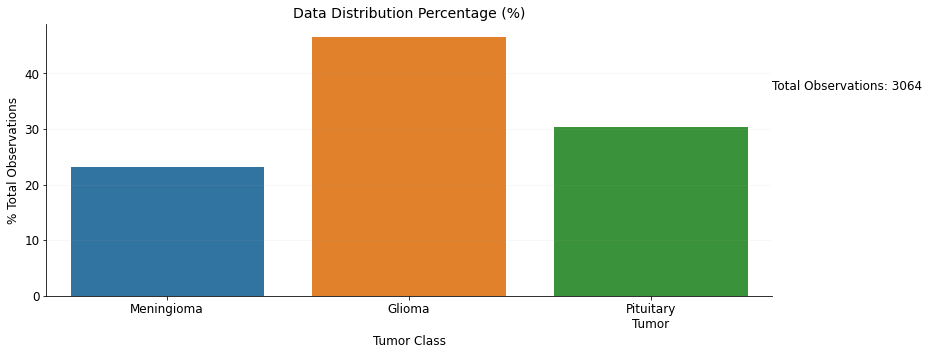

In [6]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index], 
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("Tumor Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

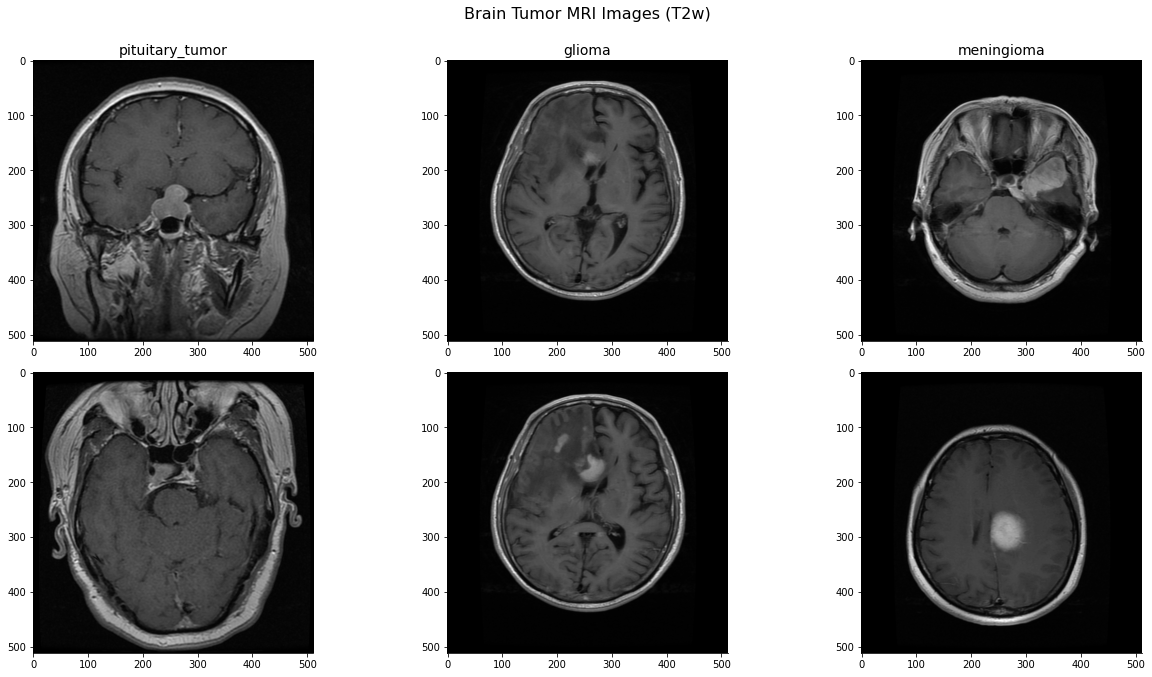

In [43]:
labels = set(df_images['class'])
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 9))
axes = axes.flatten()
fig.suptitle("Brain Tumor MRI Images (T2w)", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.04)
for i, curr_axis in zip( labels , axes[:3]):
    df_t =df_images.loc[df_images['class'] == i].reset_index(drop=True)
    curr_axis.imshow(df_t['image'][0], cmap = 'gray')
    curr_axis.set_title(df_t['class'][0], fontsize = 14)

for i, curr_axis in zip( labels , axes[3:]):
    df_t =df_images.loc[df_images['class'] == i].reset_index(drop=True)
    curr_axis.imshow(df_t['image'][1], cmap = 'gray')

fig.tight_layout()
sns.despine()
plt.show()

### **6. Development of Training, Validation & Testing Dataset**

In [7]:
image_data_paths = []
labels = []
list_address = []
for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), tumor_name), os.listdir(curr_path)))
        list_address.extend(os.listdir(curr_path))

image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

# patient level
for i in list_address :
  t=i.split("/")
  t = t[-1].split(".")
  t = t[0].split("_")
  labels.append(int(t[-1]))
e = pd.Series(labels)
image_data_paths_df_p = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class'])
image_data_paths_df_p = image_data_paths_df.assign(patient_id=e.values)


In [8]:
image_data_paths_df.info()
train_data, validation_data = train_test_split(image_data_paths_df, 
                                               train_size = 0.80, 
                                               random_state = 42, 
                                               stratify = image_data_paths_df.tumor_class)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3064 entries, 0 to 3063
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_filepaths  3064 non-null   object
 1   tumor_class      3064 non-null   object
dtypes: object(2)
memory usage: 48.0+ KB


## **7. Data/Image Augmentation**


In [9]:
# previous generator
image_size = 224
batch_size = 32

image_datagen_kwargs = dict(fill_mode = 'constant',
                            rotation_range = 10, 
                            width_shift_range = 0.1, 
                            zoom_range = 0.01, 
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.0],
                            horizontal_flip = True,
                            vertical_flip = True)

train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

train_dataset = train_image_datagen.flow_from_dataframe(train_data, 
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'tumor_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data, 
                                                                  x_col = 'image_filepaths', 
                                                                  y_col = 'tumor_class', 
                                                                  seed = 42,
                                                                  batch_size = batch_size, 
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')


Found 2451 validated image filenames belonging to 3 classes.
Found 613 validated image filenames belonging to 3 classes.


In [10]:
print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end = '\n\n')

Information about Training Dataset:
{'glioma': 0, 'meningioma': 1, 'pituitary_tumor': 2}
(224, 224, 3)



## **8. Model Development**

In [11]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

def F1_score(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    recall = true_positives / (possible_positives + backend.epsilon())
    return 2*(precision*recall)/(precision+recall+backend.epsilon())

def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['Loss', 'Accuracy','Precison','Recall', 'F1-Score'])
    y_hat = test_dataset.classes 
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        loss, accuracy ,precison, recall, f1_score= curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [loss, accuracy ,precison, recall, f1_score]
    report_df.index = row_indexes
    return report_df

### **8.1 ResNet**

#### **8.1.1 Image-level ResNet**

In [73]:
resnet_model = ResNet50(weights = 'imagenet',include_top = True, 
                                 input_shape = (image_size, image_size, 3))
len_model = len(resnet_model.layers)
for i in range(len_model):
  if i< len_model-2:
      resnet_model.layers[i].trainable = False
  else : 
    resnet_model.layers[i].trainable = True

resnet_cnn_model = Sequential()
resnet_cnn_model.add(resnet_model)
resnet_cnn_model.add(Flatten(name = 'Flatten-Layer-1'))
resnet_cnn_model.add(Dense(256, activation = 'relu', name = 'Hidden-Layer-1'))
resnet_cnn_model.add(Dropout(rate = 0.3, name = 'Dropout-Layer-1'))
resnet_cnn_model.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
resnet_cnn_model.add(Dropout(rate = 0.3, name = 'Dropout-Layer-2'))
resnet_cnn_model.add(Dense(3, activation = 'softmax', name = 'Output-Layer'))
resnet_cnn_model.compile(optimizer = Adam(0.0003), loss = 'categorical_crossentropy', metrics = ['accuracy','Precision' , 'Recall',F1_score])
resnet_cnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 Flatten-Layer-1 (Flatten)   (None, 1000)              0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 256)               256256    
                                                                 
 Dropout-Layer-1 (Dropout)   (None, 256)               0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 64)                16448     
                                                                 
 Dropout-Layer-2 (Dropout)   (None, 64)                0         
                                                                 
 Output-Layer (Dense)        (None, 3)                

In [74]:
resnet_model_train_history = resnet_cnn_model.fit(train_dataset, 
                                                  batch_size = batch_size,
                                                  validation_data = validation_dataset, 
                                                  epochs = 25,callbacks = [early_stopping])

Epoch 1/25
77/77 [==============================] - 65s 788ms/step - loss: 1.0404 - accuracy: 0.5080 - precision: 0.7253 - recall: 0.0539 - F1_score: 0.0811 - val_loss: 0.9371 - val_accuracy: 0.5987 - val_precision: 0.7315 - val_recall: 0.3556 - val_F1_score: 0.4659
Epoch 2/25
77/77 [==============================] - 59s 766ms/step - loss: 0.8413 - accuracy: 0.6597 - precision: 0.7876 - recall: 0.4313 - F1_score: 0.5513 - val_loss: 0.7244 - val_accuracy: 0.6754 - val_precision: 0.8089 - val_recall: 0.5318 - val_F1_score: 0.6407
Epoch 3/25
77/77 [==============================] - 55s 719ms/step - loss: 0.6453 - accuracy: 0.7262 - precision: 0.8086 - recall: 0.6136 - F1_score: 0.6960 - val_loss: 0.5542 - val_accuracy: 0.7814 - val_precision: 0.8653 - val_recall: 0.6395 - val_F1_score: 0.7311
Epoch 4/25
77/77 [==============================] - 62s 806ms/step - loss: 0.5526 - accuracy: 0.7601 - precision: 0.8073 - recall: 0.6989 - F1_score: 0.7480 - val_loss: 0.5075 - val_accuracy: 0.7912 

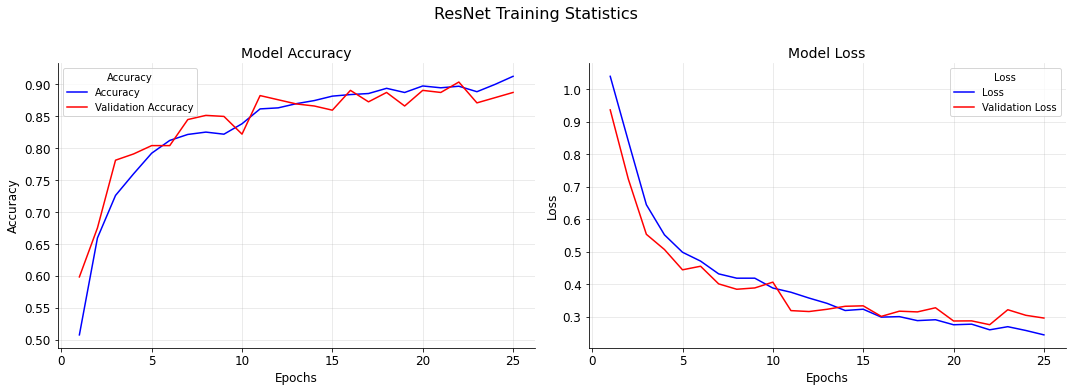

In [76]:
training_process_viz(pd.DataFrame(resnet_model_train_history.history), 
                     plot_title = 'ResNet Training Statistics')

In [81]:
resnet_report_df = generate_report(resnet_cnn_model, test_dataset = validation_dataset, row_indexes = ['ResNet'])
resnet_report_df

20/20 [==============================] - 11s 525ms/step


,Loss,Accuracy,Precison,Recall,F1-Score
ResNet,0.270064,0.892333,0.89491,0.88907,0.887991


#### **8.2.1 patient-level ResNet**

In [82]:
image_data_paths_df_p.head()
image_data_paths_df_p.sort_values('patient_id')
train_data_p, validation_data_p = train_test_split(image_data_paths_df, 
                                               train_size = 0.80, 
                                               shuffle=False)

In [83]:
train_dataset_p = train_image_datagen.flow_from_dataframe(train_data_p, 
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'tumor_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset_p = validation_image_datagen.flow_from_dataframe(validation_data_p, 
                                                                  x_col = 'image_filepaths', 
                                                                  y_col = 'tumor_class', 
                                                                  seed = 42,
                                                                  batch_size = batch_size, 
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')

Found 2451 validated image filenames belonging to 3 classes.
Found 613 validated image filenames belonging to 3 classes.


In [84]:
resnet_model = ResNet50(weights = 'imagenet',include_top = True, 
                                 input_shape = (image_size, image_size, 3))
len_model = len(resnet_model.layers)
for i in range(len_model):
  if i< len_model-2:
      resnet_model.layers[i].trainable = False
  else : 
    resnet_model.layers[i].trainable = True

resnet_cnn_model = Sequential()
resnet_cnn_model.add(resnet_model)
resnet_cnn_model.add(Flatten(name = 'Flatten-Layer-1'))
resnet_cnn_model.add(Dense(256, activation = 'relu', name = 'Hidden-Layer-1'))
resnet_cnn_model.add(Dropout(rate = 0.3, name = 'Dropout-Layer-1'))
resnet_cnn_model.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
resnet_cnn_model.add(Dropout(rate = 0.3, name = 'Dropout-Layer-2'))
resnet_cnn_model.add(Dense(3, activation = 'softmax', name = 'Output-Layer'))
resnet_cnn_model.compile(optimizer = Adam(0.0003), loss = 'categorical_crossentropy', metrics = ['accuracy','Precision' , 'Recall',F1_score])
resnet_cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 Flatten-Layer-1 (Flatten)   (None, 1000)              0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 256)               256256    
                                                                 
 Dropout-Layer-1 (Dropout)   (None, 256)               0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 64)                16448     
                                                                 
 Dropout-Layer-2 (Dropout)   (None, 64)                0         
                                                                 
 Output-Layer (Dense)        (None, 3)               

In [85]:
resnet_model_train_history = resnet_cnn_model.fit(train_dataset_p, 
                                                  batch_size = batch_size,
                                                  validation_data = validation_dataset_p, 
                                                  epochs = 25,callbacks = [early_stopping])

Epoch 1/25
77/77 [==============================] - 60s 721ms/step - loss: 1.0170 - accuracy: 0.5051 - precision: 0.7994 - recall: 0.1138 - F1_score: 0.1720 - val_loss: 0.9073 - val_accuracy: 0.6623 - val_precision: 0.7725 - val_recall: 0.3214 - val_F1_score: 0.4450
Epoch 2/25
77/77 [==============================] - 58s 756ms/step - loss: 0.8233 - accuracy: 0.6646 - precision: 0.7836 - recall: 0.4284 - F1_score: 0.5440 - val_loss: 0.6927 - val_accuracy: 0.7243 - val_precision: 0.8257 - val_recall: 0.5873 - val_F1_score: 0.6934
Epoch 3/25
77/77 [==============================] - 54s 696ms/step - loss: 0.6255 - accuracy: 0.7442 - precision: 0.8105 - recall: 0.6353 - F1_score: 0.7096 - val_loss: 0.5084 - val_accuracy: 0.7928 - val_precision: 0.8279 - val_recall: 0.7455 - val_F1_score: 0.7886
Epoch 4/25
77/77 [==============================] - 55s 716ms/step - loss: 0.5236 - accuracy: 0.7789 - precision: 0.8072 - recall: 0.7413 - F1_score: 0.7715 - val_loss: 0.4365 - val_accuracy: 0.8189 

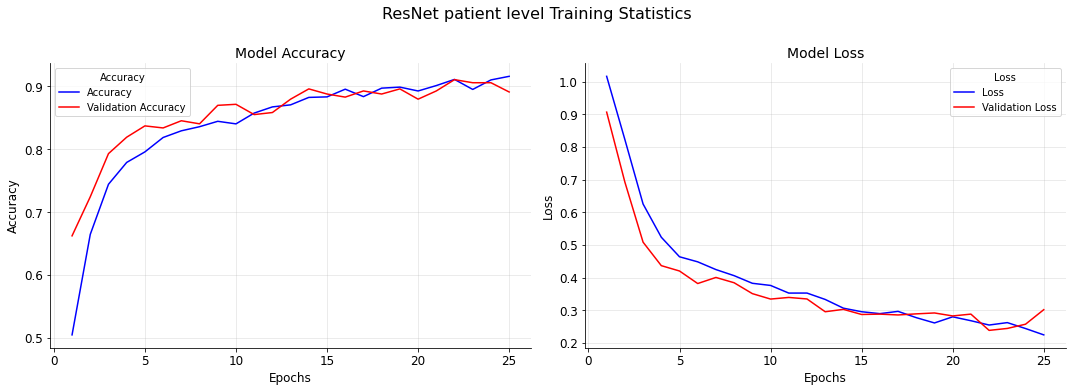

In [86]:
training_process_viz(pd.DataFrame(resnet_model_train_history.history), 
                     plot_title = 'ResNet patient level Training Statistics')

In [87]:
resnet_p_report_df = generate_report(resnet_cnn_model, test_dataset = validation_dataset_p, row_indexes = ['ResNet-pateint'])
resnet_p_report_df

20/20 [==============================] - 11s 525ms/step


,Loss,Accuracy,Precison,Recall,F1-Score
ResNet-pateint,0.266135,0.898858,0.899836,0.893964,0.901215


### **8.2 AlexNet CNN**

In [88]:
alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.3, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.3, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(3, activation = 'softmax', name = 'Output-Layer'))
optimizer = keras.optimizers.Adam(lr=0.0003)
alexnet_cnn.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy','Precision' , 'Recall',F1_score])
alexnet_cnn.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 Batch-Normalization-1 (Batc  (None, 54, 54, 96)       384       
 hNormalization)                                                 
                                                                 
 Max-Pooling-1 (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 Conv2D-2 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 Batch-Normalization-2 (Batc  (None, 26, 26, 256)      1024      
 hNormalization)                                                 
                                                     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [89]:
alexnet_train_history = alexnet_cnn.fit(train_dataset, 
                                            batch_size = batch_size,
                                            validation_data = validation_dataset, 
                                            epochs = 25,callbacks = [early_stopping])

Epoch 1/25
77/77 [==============================] - 54s 691ms/step - loss: 1.4308 - accuracy: 0.5532 - precision: 0.5710 - recall: 0.5198 - F1_score: 0.5435 - val_loss: 0.9552 - val_accuracy: 0.5856 - val_precision: 0.6489 - val_recall: 0.3980 - val_F1_score: 0.4811
Epoch 2/25
77/77 [==============================] - 51s 664ms/step - loss: 0.7447 - accuracy: 0.6691 - precision: 0.7030 - recall: 0.6112 - F1_score: 0.6538 - val_loss: 0.6770 - val_accuracy: 0.6884 - val_precision: 0.7280 - val_recall: 0.5808 - val_F1_score: 0.6377
Epoch 3/25
77/77 [==============================] - 51s 659ms/step - loss: 0.7324 - accuracy: 0.6716 - precision: 0.7054 - recall: 0.6214 - F1_score: 0.6603 - val_loss: 0.6913 - val_accuracy: 0.6444 - val_precision: 0.6781 - val_recall: 0.6150 - val_F1_score: 0.6517
Epoch 4/25
77/77 [==============================] - 51s 662ms/step - loss: 0.6904 - accuracy: 0.6907 - precision: 0.7256 - recall: 0.6267 - F1_score: 0.6711 - val_loss: 0.6878 - val_accuracy: 0.6166 

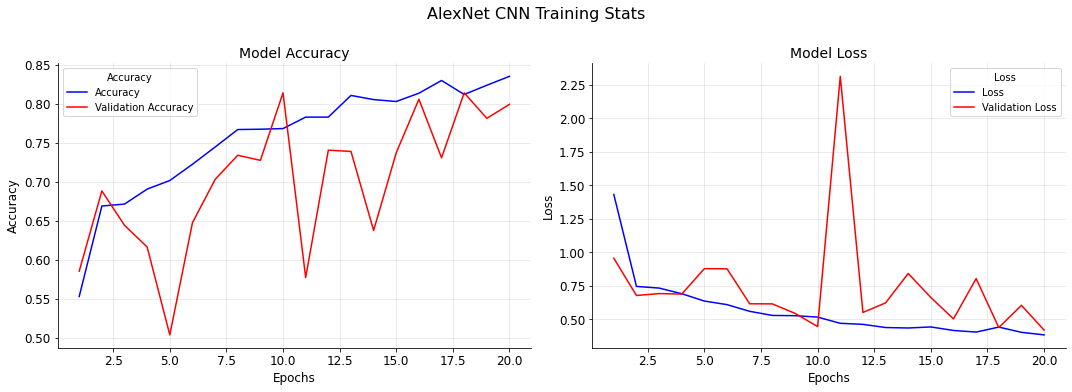

In [90]:
training_process_viz(pd.DataFrame(alexnet_train_history.history), plot_title = 'AlexNet CNN Training Stats')

In [91]:
alexnet_report_df = generate_report(alexnet_cnn, test_dataset = validation_dataset, row_indexes = ['AlexNet CNN'])
alexnet_report_df

20/20 [==============================] - 10s 515ms/step


,Loss,Accuracy,Precison,Recall,F1-Score
AlexNet CNN,0.387195,0.838499,0.857877,0.817292,0.83518


### **8.3 Multi-Layer Perceptron**

In [15]:
image_size = 128
train_dataset = train_image_datagen.flow_from_dataframe(train_data, 
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'tumor_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data, 
                                                                  x_col = 'image_filepaths', 
                                                                  y_col = 'tumor_class', 
                                                                  seed = 42,
                                                                  batch_size = batch_size, 
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')


Found 2451 validated image filenames belonging to 3 classes.
Found 613 validated image filenames belonging to 3 classes.


In [16]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = (image_size, image_size, 3), name = 'Flatten-Layer'))
mlp_model.add(Dense(2048, activation = 'relu', name = 'Hidden-Layer-1'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-1'))
mlp_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-2'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-2'))
mlp_model.add(Dense(512, activation = 'relu', name = 'Hidden-Layer-3'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-3'))
mlp_model.add(Dense(3, activation = 'softmax', name = 'Output-Layer-1'))
optimizer = keras.optimizers.Adam(lr=0.0003)
mlp_model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy','Precision','Recall',F1_score])
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten-Layer (Flatten)     (None, 49152)             0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 2048)              100665344 
                                                                 
 Dropout-Layer-1 (Dropout)   (None, 2048)              0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 1024)              2098176   
                                                                 
 Dropout-Layer-2 (Dropout)   (None, 1024)              0         
                                                                 
 Hidden-Layer-3 (Dense)      (None, 512)               524800    
                                                                 
 Dropout-Layer-3 (Dropout)   (None, 512)              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
mlp_train_history = mlp_model.fit(train_dataset,
                                      batch_size = batch_size,
                                      validation_data = validation_dataset,
                                      epochs = 25,callbacks = [early_stopping])

Epoch 1/25
77/77 [==============================] - 263s 3s/step - loss: 570.9412 - accuracy: 0.4655 - precision: 0.4655 - recall: 0.4655 - F1_score: 0.4656 - val_loss: 50.3931 - val_accuracy: 0.5856 - val_precision: 0.5856 - val_recall: 0.5856 - val_F1_score: 0.5862
Epoch 2/25
77/77 [==============================] - 77s 997ms/step - loss: 108.4562 - accuracy: 0.5063 - precision: 0.5063 - recall: 0.5063 - F1_score: 0.5073 - val_loss: 49.9683 - val_accuracy: 0.5400 - val_precision: 0.5400 - val_recall: 0.5400 - val_F1_score: 0.5425
Epoch 3/25
77/77 [==============================] - 79s 1s/step - loss: 42.1966 - accuracy: 0.5222 - precision: 0.5222 - recall: 0.5222 - F1_score: 0.5220 - val_loss: 16.7864 - val_accuracy: 0.4992 - val_precision: 0.4992 - val_recall: 0.4992 - val_F1_score: 0.4950
Epoch 4/25
77/77 [==============================] - 77s 992ms/step - loss: 13.5706 - accuracy: 0.4765 - precision: 0.5035 - recall: 0.4431 - F1_score: 0.4635 - val_loss: 1.3599 - val_accuracy: 0.3

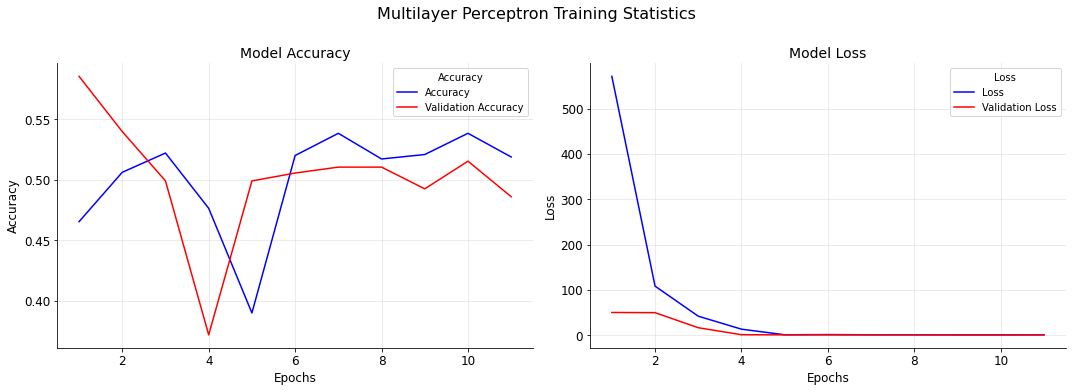

In [18]:
training_process_viz(pd.DataFrame(mlp_train_history.history), 
                     plot_title = 'Multilayer Perceptron Training Statistics')

In [19]:
mlp_report_df = generate_report(mlp_model, 
                                test_dataset = validation_dataset, 
                                row_indexes = ("Multi-Layer-Perceptron Model",))
mlp_report_df

20/20 [==============================] - 11s 511ms/step


,Loss,Accuracy,Precison,Recall,F1-Score
Multi-Layer-Perceptron Model,1.04034,0.486134,0.846154,0.017945,0.032799


## **9. Conclusions**

* The **pre-trained (imagenet) ResNet** model has performed the best among Multi-Layer perceptron and AlexNet CNN models with an accuracy of $89.88\%$ in 25 epochs. 

In [ ]:
final_report_df = pd.concat([mlp_report_df, alexnet_report_df,resnet_p_report_df, resnet_report_df])
final_report_df

####questions:

1&2- How close are your answers to those in the paper?Why do you think they aren't close if they aren't?

> the ratio between answers are as similar as the paper but because of lack of GPU I can not get the exact reuslt of paper


3- What suggestions do you have for improving any of these methods?


> I think all of these methods will improve if we add attention layer to them (to learn the important part of image). Moreover, I think if we use all of field in dicom file of data, we could extract more useful information and get better result.


4- Compare the results from these 3 models. How would you rate each method in terms of its effectiveness?


> As we say in previous blocks, Resnet is in first place, after that is AlexNet and the last place is for MLP model.


5- Can we trust our answer for any MRI image of a patient? Answer the question in detail.


> No, Because the Accuracy of our model is really low and can not get the quallity of doctors. So we can not trust them without suprivision of a human on it. but if we add a confidence parameter to models, they could use in a semi-automate framework; wich means for data with high confidence we automaticlly generate the result but for data in low confidence we use doctor opinion to make final result.
